앙상블(ensemble) 

앙상블 기법이란 여러 개의 분류 모델을 조합해서 더 나은 성능을 내는 방법이다.  
최근접 이웃, 서포트 벡터 머신, 의사결정 트리, 나이브 베이즈 분류 모델을 실습했는데 지금까지 실습한 여러 분류 모델을 조합해서 단일 모델보다 더 좋은 성능을 낸다.

배깅(Bagging)

배깅(bagging)의 어원은 부트스트랩(bootstrap)과 어그리게이팅(aggregating, 집계)에서 왔고 상당히 연주하기 힘든 바이올린 연주곡을 두세 명의 초급 바이올린 연주자가 나누어 연주함으로써 한 명의 중급 바이올린 연주자가 연주하는 것 보다 더 나은 연주를 할 수 있는 것과 유사하다.  
중급 바이올린 연주자는 나름 잘 학습했지만 학습 데이터에 과대적합된 의사결정 트리라 볼 수 있다. 의사결정 트리의 단점은 쉽게 과대적합된다는 것인데 배깅은 과대적합이 쉬운 모델에 상당히 적합한 앙상블이다.  
배깅은 한 가지 분류 모델을 여러 개 만들어서 서로 다른 학습 데이터로 학습시킨 후(부트스트랩), 동일한 테스트 데이터에 대한 서로 다른 예측값들을 투표를 통해(어그리게이팅) 가장 높은 예측값으로 최종 결론을 내리는 앙상블 기법이다.  
<img src="./images/ensemble.png" align="left" width="1300"/>  
<img src="./images/ensemble2.png" align="left" width="1300"/>  
<img src="./images/ensemble3.png" align="left" width="1300"/>

랜덤 포레스트(Random Forest)  

여러 의사결정 트리를 배깅을 적용해서 예측을 실행하는 모델이다.  
배깅이 모든 분류 모델에서 적용 가능하지만 특히 과대적합되기 쉬운 의사결정 트리에 적용하면 확실히 과대적합을 줄여 성능이 높아지는 혜택을 보기 때문에 배깅은 많은 의사결정 트리 모델의 개선을 이뤘고 여러 개의 나무들이 모여있다는 개념에서 랜덤 포레스트라는 이름이 생겨났다.  

의사결정 트리에서 최적의 특징으로 트리를 분기하는 반면 랜덤 포레스트는 각 노드에 주어진 데이터를 샘플링해서 일부 데이터를 제외한 채 최적의 특징을 찾아 트리를 분기한다. 이러한 과정에서 랜덤 포레스트는 또 한 번 모델의 편향을 증가시켜 과대적합의 위험을 감소시킨다.

부스팅(Boosting)  

여러 개의 분류기를 만들어 투표를 통해 예측값을 결정한다는 측면에서는 배깅과 동일하다.  
배깅은 서로 다른 알고리즘에 기반한 여러 분류기를 병렬적으로 학습하는 반면에 부스팅은 동일한 알고리즘의 분류기를 순차적으로 학습해서 여러 개의 분류기를 만든 후 테스트할 때 가중 투표를 통해 예측값을 결정한다.

In [1]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# 사이킷런이 제공하는 MNIST 손글씨 데이터를 불러오기 위해 import 한다.
from sklearn.datasets import load_digits
# 교차검증을 하기위해 import 한다.
from sklearn.model_selection import cross_val_score
from sklearn import tree # 의사결정 트리를 import 한다.
from sklearn.ensemble import RandomForestClassifier # 랜덤 포레스트 분류기를 import 한다.
import matplotlib.pyplot as plt

MNIST 손글씨 데이터셋으로 랜덤 포레스트 모델과 의사결정 트리 모델을 동일하게 학습시켜 두 모델의 성능 차이를 시각화해 비교한다.

MNIST 손글씨 데이터 불러오기

In [3]:
mnist = load_digits() # 사이킷런이 제공하는 MNIST 손글씨 데이터셋을 얻어온다.
#print(mnist)
#features = mnist.data
#labels = mnist.target
features, labels = mnist.data, mnist.target
print(features.shape, labels.shape)

(1797, 64) (1797,)


In [4]:
print(type(features[0]))
print(features[0].reshape(8, 8), labels[0])

<class 'numpy.ndarray'>
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]] 0


교차 검증

사이킷런의 cross_val_score() 함수는 데이터를 k개로 나눠서 k번 정확도를 검증하는 k-fold 교차검증을 수행한다. cross_val_score(model, X, Y, scoring=None, cv=None)  
model: 분석 모델  
X: 독립 변수, 학습 데이터(피처)  
Y: 종속 변수, 학습 결과(라벨, 타겟)  
scoring: 성능 검증에 사용할 매개 변수로 원하는 평가 지표를 지정한다. => 정확도를 의미하는 'accuracy'를 지정한다.  
cv: 교차 검증 생성기 객체 또는 숫자, None이면 KFold(3), 숫자를 지정하면 KFold(숫자)

MNIST 데이터에 대한 의사결정 트리와 랜덤 포레스트의 검증 정확도를 계산하는 함수

In [5]:
# cross_validation(분류기 모델, 학습 데이터에 따른 레이블)
def cross_validation(classifier, features, labels):
    cv_scores = []
    for i in range(10):
        scores = cross_val_score(classifier, features, labels, scoring='accuracy', cv=10)
        # print(scores, scores.mean())
        cv_scores.append(scores.mean())
    return cv_scores

의사결정 트리의 MNIST 손글씨 검증 정확도를 계산한다.

In [6]:
dt_cv_scores = cross_validation(tree.DecisionTreeClassifier(), features, labels)
for i in range(len(dt_cv_scores)):
    print('{:2d}. {:7.5f}'.format(i + 1, dt_cv_scores[i]), end=' ')

 1. 0.82748  2. 0.82579  3. 0.82971  4. 0.82245  5. 0.83137  6. 0.83249  7. 0.83360  8. 0.82636  9. 0.83583 10. 0.82583 

랜덤 포레스트의 MNIST 손글씨 검증 정확도를 계산한다.

In [7]:
rf_cv_scores = cross_validation(RandomForestClassifier(), features, labels)
for i in range(len(rf_cv_scores)):
    print('{:2d}. {:7.5f}'.format(i + 1, rf_cv_scores[i]), end=' ')

 1. 0.95101  2. 0.95325  3. 0.94768  4. 0.94713  5. 0.94768  6. 0.94991  7. 0.94712  8. 0.95158  9. 0.94991 10. 0.94713 

의사결정 트리 vs 랜덤 포레스트 시각화

In [8]:
cv_dict = {'decision_tree': dt_cv_scores, 'random_forest': rf_cv_scores}
df = pd.DataFrame(cv_dict)
df

,decision_tree,random_forest
0,0.827477,0.951015
1,0.825791,0.953250
2,0.829711,0.947675
3,0.822449,0.947126
4,0.831375,0.947682
5,0.832486,0.949910
6,0.833600,0.947120
7,0.826359,0.951583
8,0.835826,0.949913
9,0.825829,0.947129


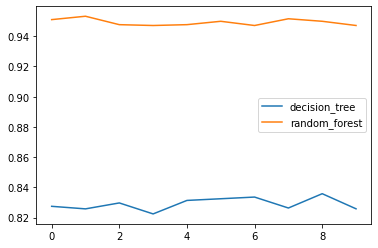

In [9]:
df.plot()
plt.show()

최종 정확도

In [10]:
print('의사결정 트리: {:%}'.format(np.mean(dt_cv_scores)))
print('랜덤 포레스트: {:%}'.format(np.mean(rf_cv_scores)))

의사결정 트리: 82.909032%
랜덤 포레스트: 94.924022%
